In [63]:
!git clone https://github.com/root-yash/DeepLearningExamples.git

Cloning into 'DeepLearningExamples'...
remote: Enumerating objects: 32677, done.
remote: Counting objects: 100% (500/500), done.
remote: Compressing objects: 100% (331/331), done.
remote: Total 32677 (delta 164), reused 481 (delta 161), pack-reused 32177
Receiving objects: 100% (32677/32677), 106.09 MiB | 21.16 MiB/s, done.
Resolving deltas: 100% (23044/23044), done.


In [ ]:
pip install monai

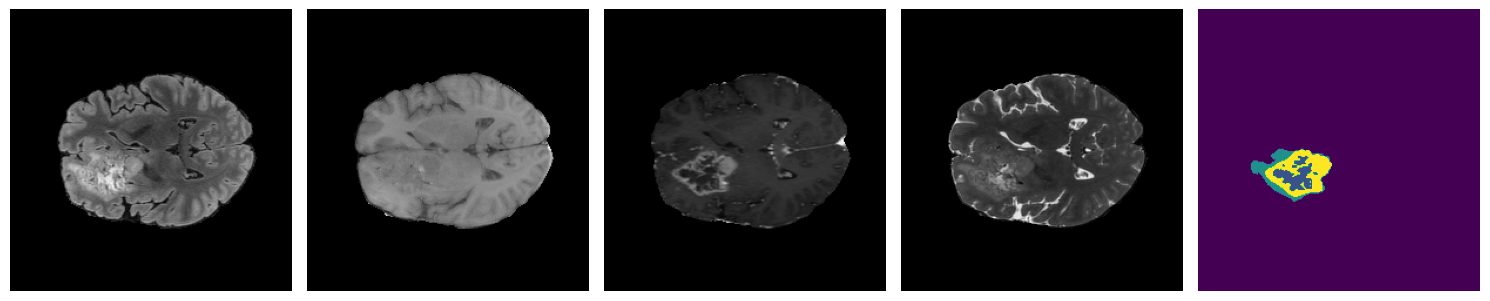

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from glob import glob
import tarfile
import os 
import shutil

file = tarfile.open('/kaggle/input/brats-2021-task1/BraTS2021_Training_Data.tar')
file.extractall('/kaggle/working/training')

os.mkdir("/kaggle/working/validation")
for i in os.listdir("/kaggle/working/training")[:120]:
    shutil.move("training/"+i, "validation/"+i)
    
imgs = [nib.load(f"training/BraTS2021_00000/BraTS2021_00000_{m}.nii.gz").get_fdata().astype(np.float32)[:, :, 75] for m in ["flair", "t1", "t1ce", "t2"]]
lbl = nib.load("training/BraTS2021_00000/BraTS2021_00000_seg.nii.gz").get_fdata().astype(np.uint8)[:, :, 75]

fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15, 15))
for i, img in enumerate(imgs):
    ax[i].imshow(img, cmap='gray')
    ax[i].axis('off')
ax[-1].imshow(lbl, vmin=0, vmax=4)
ax[-1].axis('off')
plt.tight_layout()            
plt.show()

In [54]:
import json
import os
from glob import glob
from subprocess import call
import time

import nibabel
import numpy as np
from joblib import Parallel, delayed


def load_nifty(directory, example_id, suffix):
    return nibabel.load(os.path.join(directory, example_id + "_" + suffix + ".nii.gz"))


def load_channels(d, example_id):
    return [load_nifty(d, example_id, suffix) for suffix in ["flair", "t1", "t1ce", "t2"]]


def get_data(nifty, dtype="int16"):
    if dtype == "int16":
        data = np.abs(nifty.get_fdata().astype(np.int16))
        data[data == -32768] = 0
        return data
    return nifty.get_fdata().astype(np.uint8)

def deletefile(file_list):
    for i in file_list:
        os.remove(i)
        
def prepare_nifty(d):

    example_id = d.split("/")[-1]
    flair, t1, t1ce, t2 = load_channels(d, example_id)
    affine, header = flair.affine, flair.header
    vol = np.stack([get_data(flair), get_data(t1), get_data(t1ce), get_data(t2)], axis=-1)
    vol = nibabel.nifti1.Nifti1Image(vol, affine, header=header)
    nibabel.save(vol, os.path.join(d, example_id + ".nii.gz"))
    
    if os.path.exists(os.path.join(d, example_id + "_seg.nii.gz")):
        seg = load_nifty(d, example_id, "seg")
        affine, header = seg.affine, seg.header
        vol = get_data(seg, "unit8")
        vol[vol == 4] = 3
        seg = nibabel.nifti1.Nifti1Image(vol, affine, header=header)
        nibabel.save(seg, os.path.join(d, example_id + "_seg.nii.gz"))
        
    deletefile([os.path.join(d, example_id + "_" + suffix + ".nii.gz") for suffix in ["flair", "t1", "t1ce", "t2"]])

        
def prepare_dirs(data, train):
    img_path, lbl_path = os.path.join(data, "images"), os.path.join(data, "labels")
    call(f"mkdir {img_path}", shell=True)
    if train:
        call(f"mkdir {lbl_path}", shell=True)
    dirs = glob(os.path.join(data, "BraTS*"))
    for d in dirs:
        if "_" in d.split("/")[-1]:
            files = glob(os.path.join(d, "*.nii.gz"))
            for f in files:
                if "flair" in f or "t1" in f or "t1ce" in f or "t2" in f:
                    continue
                if "_seg" in f:
                    call(f"mv {f} {lbl_path}", shell=True)
                else:
                    call(f"mv {f} {img_path}", shell=True)
        call(f"rm -rf {d}", shell=True)


def prepare_dataset_json(data, train):
    images, labels = glob(os.path.join(data, "images", "*")), glob(os.path.join(data, "labels", "*"))
    images = sorted([img.replace(data + "/", "") for img in images])
    labels = sorted([lbl.replace(data + "/", "") for lbl in labels])

    modality = {"0": "FLAIR", "1": "T1", "2": "T1CE", "3": "T2"}
    labels_dict = {"0": "background", "1": "edema", "2": "non-enhancing tumor", "3": "enhancing tumour"}
    if train:
        key = "training"
        data_pairs = [{"image": img, "label": lbl} for (img, lbl) in zip(images, labels)]
    else:
        key = "test"
        data_pairs = [{"image": img} for img in images]

    dataset = {
        "labels": labels_dict,
        "modality": modality,
        key: data_pairs,
    }

    with open(os.path.join(data, "dataset.json"), "w") as outfile:
        json.dump(dataset, outfile)


def run_parallel(func, args):
    return Parallel(n_jobs=os.cpu_count())(delayed(func)(arg) for arg in args)


def prepare_dataset(data, train):
    print(f"Preparing BraTS21 dataset from: {data}")
    start = time.time()
    run_parallel(prepare_nifty, sorted(glob(os.path.join(data, "BraTS*"))))
    prepare_dirs(data, train)
    prepare_dataset_json(data, train)
    end = time.time()
    print(f"Preparing time: {(end - start):.2f}")

prepare_dataset("training", True)
prepare_dataset("validation", False)
print("Finished!")

Preparing BraTS21 dataset from: training


KeyboardInterrupt: 

Now, lets preprocesses the datasets by cropping and normalizing the volumes. We will store the pre-processed volumes as NumPy arrays.

In [59]:
!python3 DeepLearningExamples/PyTorch/Segmentation/nnUNet/preprocess.py --task 11 --ohe --exec_mode training
!python3 DeepLearningExamples/PyTorch/Segmentation/nnUNet/preprocess.py --task 12 --ohe --exec_mode test
print("Finished!")

Traceback (most recent call last):
  File "DeepLearningExamples/PyTorch/Segmentation/nnUNet/preprocess.py", line 42, in <module>
    Preprocessor(args).run()
  File "/kaggle/working/DeepLearningExamples/PyTorch/Segmentation/nnUNet/data_preprocessing/preprocessor.py", line 42, in __init__
    self.metadata = json.load(open(metadata_path, "r"))
FileNotFoundError: [Errno 2] No such file or directory: '/data/BraTS2021_train/dataset.json'
^C
Traceback (most recent call last):
  File "DeepLearningExamples/PyTorch/Segmentation/nnUNet/preprocess.py", line 19, in <module>
    from data_preprocessing.preprocessor import Preprocessor
  File "/kaggle/working/DeepLearningExamples/PyTorch/Segmentation/nnUNet/data_preprocessing/preprocessor.py", line 21, in <module>
    import monai.transforms as transforms
  File "/opt/conda/lib/python3.7/site-packages/monai/__init__.py", line 55, in <module>
    load_submodules(sys.modules[__name__], False, exclude_pattern=excludes)
  File "/opt/conda/lib/python3.7

In [ ]:
import torch.nn as nn
from monai.losses import DiceLoss

class Loss(nn.Module):
    def __init__(self):
        super(Loss, self).__init__()
        self.dice = DiceLoss(sigmoid=True, batch=True)
        self.ce = nn.BCEWithLogitsLoss()

    def _loss(self, p, y):
        return self.dice(p, y) + self.ce(p, y.float())

    def forward(self, p, y):
        y_wt, y_tc, y_et = y > 0, ((y == 1) + (y == 3)) > 0, y == 3
        p_wt, p_tc, p_et = p[:, 0].unsqueeze(1), p[:, 1].unsqueeze(1), p[:, 2].unsqueeze(1)
        l_wt, l_tc, l_et = self._loss(p_wt, y_wt), self._loss(p_tc, y_tc), self._loss(p_et, y_et)
        return l_wt + l_tc + l_et

In [6]:
!python DeepLearningExamples/PyTorch/Segmentation/nnUNet/main.py --brats --deep_supervision --depth 6 --filters 64 96 128 192 256 384 512 --min_fmap 2 --scheduler --learning_rate 0.0003 --epochs 30 --fold 0 --amp --gpus 1 --task 11 --save_ckpt

Global seed set to 1

Number of examples: Train 1000 - Val 251

Filters: [64, 96, 128, 192, 256, 384, 512],

Kernels: [[3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3]]

Strides: [[1, 1, 1], [2, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 2]]

GPU available: True, used: True

TPU available: False, using: 0 TPU cores

Using native 16bit precision.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name  | Type      | Params

------------------------------------

0 | model | UNet      | 50.8 M

1 | loss  | LossBraTS | 0     

2 | dice  | Dice      | 0     

------------------------------------

50.8 M    Trainable params

0         Non-trainable params

50.8 M    Total params

203.356   Total estimated model params size (MB)

Epoch 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████▉| 751/751 [02:53<00:00]

DLL 2021-10-07 09:47:10.369319 - Epoch: 0  Mean dice : 76.92  Highest : 76.92  L1 : 72.81  L2 : 7

In [7]:
!python DeepLearningExamples/PyTorch/Segmentation/nnUNet/main.py --gpus 1 --amp --save_preds --exec_mode predict --brats --data /data/12_3d/test --ckpt_path /results/checkpoints/epoch=29-dice_mean=89.69.ckpt --tta

Global seed set to 1

Number of test examples: 219

Filters: [64, 96, 128, 192, 256, 384, 512],

Kernels: [[3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3]]

Strides: [[1, 1, 1], [2, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 2], [2, 2, 2]]

GPU available: True, used: True

TPU available: False, using: 0 TPU cores

Using native 16bit precision.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

Testing: 100%|███████████████████████████████████████████████████████████████████████████████████| 219/219 [10:39<00:00]


In [8]:
import os
from glob import glob
from subprocess import call

import nibabel as nib
import numpy as np
from scipy.ndimage.measurements import label


def to_lbl(pred):
    enh = pred[2]
    c1, c2, c3 = pred[0] > 0.5, pred[1] > 0.5, pred[2] > 0.5
    pred = (c1 > 0).astype(np.uint8)
    pred[(c2 == False) * (c1 == True)] = 2
    pred[(c3 == True) * (c1 == True)] = 4

    components, n = label(pred == 4)
    for et_idx in range(1, n + 1):
        _, counts = np.unique(pred[components == et_idx], return_counts=True)
        if 1 < counts[0] and counts[0] < 8 and np.mean(enh[components == et_idx]) < 0.9:
            pred[components == et_idx] = 1

    et = pred == 4
    if 0 < et.sum() and et.sum() < 73 and np.mean(enh[et]) < 0.9:
        pred[et] = 1

    pred = np.transpose(pred, (2, 1, 0)).astype(np.uint8)
    return pred


def prepare_preditions(e):
    fname = e[0].split("/")[-1].split(".")[0]
    preds = [np.load(f) for f in e]
    p = to_lbl(np.mean(preds, 0))

    img = nib.load(f"/data/BraTS2021_val/images/{fname}.nii.gz")
    nib.save(
        nib.Nifti1Image(p, img.affine, header=img.header),
        os.path.join("/results/final_preds", fname + ".nii.gz"),
    )

os.makedirs("/results/final_preds")
preds = sorted(glob(f"/results/predictions*"))
examples = list(zip(*[sorted(glob(f"{p}/*.npy")) for p in preds]))
print("Preparing final predictions")
for e in examples:
    prepare_preditions(e)
print("Finished!")

Preparing final predictions

Finished!


# Visualization

Let's visualize the final prediction made on the challenge validation dataset.

BraTS2021_00001


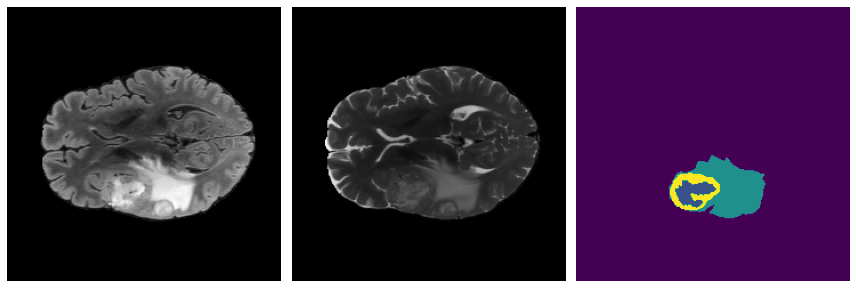

BraTS2021_00013


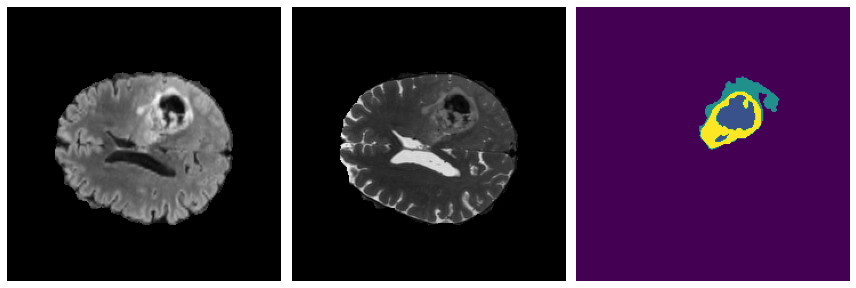

BraTS2021_00015


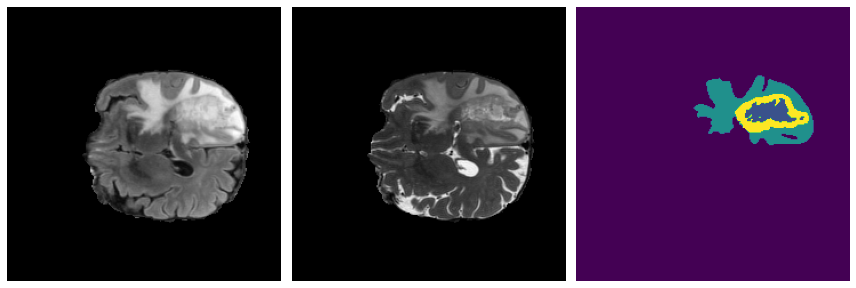

BraTS2021_00027


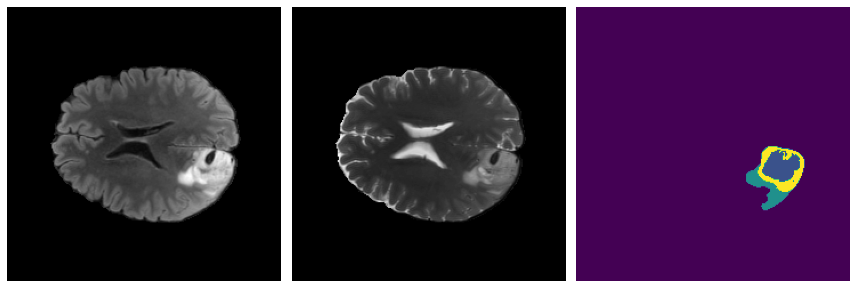

BraTS2021_00037


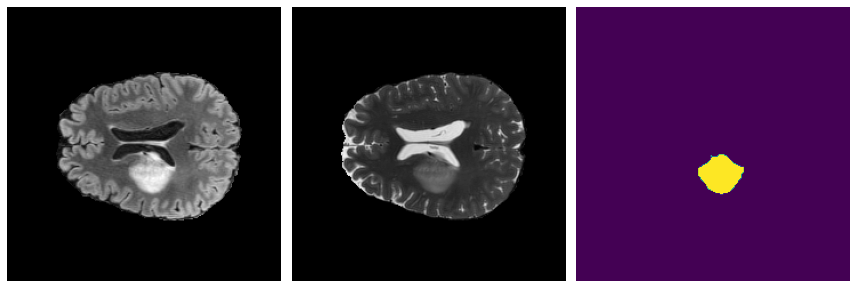

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from glob import glob

n, z = 5, 75
data = sorted(glob("/results/final_preds/*.nii.gz"))
for i in range(n):
    fname = data[i].split("/")[-1].split(".")[0]
    print(fname)
    img = nib.load(f"/data/BraTS2021_val/images/{fname}.nii.gz").get_fdata().astype(np.float32)
    pred = nib.load(data[i]).get_fdata().astype(np.uint8)[:, :, z]
    imgs = [img[:, :, z, i] for i in [0, 3]] + [pred]
    
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 12))
    for i in range(3):
        if i < 2:
            ax[i].imshow(imgs[i], cmap='gray')
        else:
            ax[i].imshow(imgs[i]);
        ax[i].axis('off')  
    plt.tight_layout()            
    plt.show()

In [ ]:
shutil.rmtree("/kaggle/working/training")
shutil.rmtree("/kaggle/working/validation")